<a href="https://colab.research.google.com/github/AmauryFaure/project_article_1/blob/master/Project_A1_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Inspire :

Notebook réalisé par Amaury Faure dans le cadre d'un projet d'intégration G3 réalisé avec INSPIRE, un des programmes de l'association Article 1. 

Ce notebook contient des explorations d'algorithmes simples de classification de messages. On utilise dans ce notebook le BoW et TF-IDF conjugé à une régréssion logistique. 


## Initialisation:

In [1]:
#Connecting to Drive to get files.
#Other options is to upload files to local machine (if using google colab)
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
#Importing pandas and numpy
import pandas as pd
import numpy as np

## Création du dataset d'entaînement :

In [3]:
#Get tweets
df_to_moderate=pd.read_csv("/content/drive/MyDrive/article_1_data/selected_tweets.csv")
#Drop unused data
df_to_moderate=df_to_moderate.drop(["Id","source","Looked up word"],axis=1)
#Change column name
df_to_moderate["content"]=df_to_moderate["tweet (without @)"]
df_to_moderate=df_to_moderate.drop(["tweet (without @)"], axis=1)
#Drop empty lines
df_to_moderate=df_to_moderate.dropna()

In [4]:
#Get regular data
df_article1_messages=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuNormal")
#Drop unused data
df_article1_messages=df_article1_messages.drop(["_id","sender","recipients.0","threadId","timestamp","EchantillonNormal"], axis=1)
#Assign label
df_article1_messages["Harmful"]=0

In [5]:
#Create training dataset. Balanced 50% for each class !
df_to_moderate=pd.concat([df_article1_messages[:200],df_to_moderate],ignore_index=True)

## Création du dataset de test :

Il y a un problème car nous n'avons pas de dataset d'exemples de message "a modérer" d'INSPIRE.

On va donc tenter une analyse par 2 approches :
- Test sur le dataset de tweets MLMA (sans les tweets d'entraînement)
- Evaluation du % de messages d'Article 1 qui sont identifié comme messages à modérer actuellement et qui sont identifié comme à modéré par l'algorithme. 


### Création du set de test MLMA :

In [6]:
test=pd.read_csv("/content/drive/MyDrive/article_1_data/fr_dataset_test.csv")
#Dropping Unused columns
test=test.drop(test.columns[[7,8,9]],axis=1)
test=test.drop(columns=["HITId","directness","annotator_sentiment","target","group"])
#Changing sentiment to 0 (for normal) and 1 (for else) 
test["sentiment"]=[0 if test["sentiment"][x]=="normal" else 1 for x in range(test.shape[0])]

### Création du set de test INSPIRE :

In [7]:
df_a1_to_moderate=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuToModerate")
df_a1_to_moderate=df_a1_to_moderate.drop(columns=["_id","sender","recipients.0","threadId","timestamp","EchantillonToModerate"])
# df_a1_to_moderate.columns=df_a1_to_moderate.columns.str.replace("\n"," ")
df_a1_to_moderate.head()

,content
0,"Non, la physique-chimie de lycée n’a pas grand..."
1,Merci infiniment d'avoir pris autant de temps ...
2,Bonjour ! Alors non la SVT et la biologie ce n...
3,salut\nJ'aimerais savoir ce qu'est exactement ...
4,je sais pas si j'ai répondu à toutes tes quest...


## Mise en place de Bag Of Words et TF-IDF :

Création de variables :


In [8]:
#Creating arrays for test_values and labels
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])
# Same but for training
train_values=np.array(df_to_moderate["content"])
#Extra step to Making sure everything is on a string format (some numbers might not be)
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

Création d'un fonction pour le calcul des métriques :

In [9]:


#Import SGDClassifier (allows to implement logistic regression)
from sklearn.linear_model import SGDClassifier
#Import matplotlib for plots
%matplotlib inline
import matplotlib.pyplot as plt
#Import some metrics
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, confusion_matrix
#Import seaborn for plots
import seaborn as sns

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes F1-score
def calc_f1(p_and_r):
    p, r = p_and_r
    return (2*p*r)/(p+r)

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes some metrics
def compute_metrics(y_test, y_prob, verbose=False, return_metrics=True, confusion=False):
  precision, recall, threshold = precision_recall_curve(y_test, y_prob, pos_label = 1)

  #Optimizing the F1-score
  best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
  best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

  y_test_pred = np.where(y_prob > best_threshold, 1, 0)
  
  f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = 'binary')
  roc_auc = roc_auc_score(y_test, y_prob)
  acc = accuracy_score(y_test, y_test_pred)

  if confusion:
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Not harmful', 'Harmful'], yticklabels = ['Not harmful', 'Harmful'], annot_kws={"size": 14}, cmap = 'Blues')# font size

    plt.xlabel('Prediction')
    plt.ylabel('Truth')

  if verbose:
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
  if return_metrics:
    return np.array([f1, best_precision, best_recall, roc_auc, acc])

#Defining a function to do 10 times the logistic regression
def evaluate_log_reg(train_features, test_features, y_train, y_test):
    score=0
    metrics = np.zeros(5)
    for i in range(10):
        log_reg=SGDClassifier(loss="log", penalty='l2')
        log_reg.fit(train_features,y_train)
      
        y_prob=log_reg.predict_proba(test_features)[:,1]
        metrics+=compute_metrics(y_test,y_prob)
    metrics /=10

    return metrics


### Bag of Word :

In [10]:
# Bag of Word
from sklearn.feature_extraction.text import CountVectorizer
#Declaring the vectorizer
bow=CountVectorizer()
#Fiting the model to the training dataset, and vectorizing the training dataset
train_bow=bow.fit_transform(train_values)
#Vectorizing test dataset
test_bow=bow.transform(test_values)
#Real metrics
metrics_bow=evaluate_log_reg(train_bow, test_bow, train_labels, test_labels)
#Metrics evaluated on train dataset (to see if overfitting)
metrics_train=evaluate_log_reg(train_bow, train_bow, train_labels, train_labels)

### TF-IDF :

In [11]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer()
train_tfidf=tfidf.fit_transform(train_values)
test_tfidf=tfidf.transform(test_values)

metrics_tfidf=evaluate_log_reg(train_tfidf, test_tfidf, train_labels, test_labels)
metrics_train_tfidf=evaluate_log_reg(train_tfidf, train_tfidf, train_labels, train_labels)

In [12]:
metrics_df=pd.DataFrame(metrics_bow.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"], index=["BoW"])
df2=pd.DataFrame(metrics_tfidf.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"], index=["TF-IDF"])
metrics_df=metrics_df.append(df2)

In [13]:
metrics_df.head()

,f1,best_precision,best_recall,roc_auc,acc
BoW,0.886471,0.797094,0.998827,0.595706,0.796569
TF-IDF,0.886598,0.797417,0.998605,0.652224,0.796872


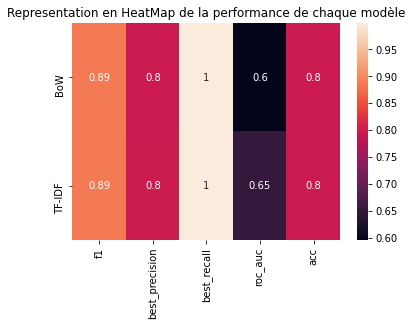

In [14]:
sns.heatmap(metrics_df, annot=True)
plt.title("Representation en HeatMap de la performance de chaque modèle")
plt.show()

Les deux modèles semblent offrir des performances très similaires sur le set de test MLMA hormis sur l'air sur la courbe ROC où TF-IDF est meilleur que BoW. 

## Analyse : Quelles implications sur les messages à modérer A1 ? 




### Test avec BoW :

In [15]:
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])

train_values=np.array(df_to_moderate["content"])
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

In [16]:
#Entrainement d'un Bow
bow=CountVectorizer()
train_bow=bow.fit_transform(train_values)
test_bow=bow.transform(test_values)

log_reg=SGDClassifier(loss="log", penalty='l2')
log_reg.fit(train_bow,train_labels)

prediction=log_reg.predict(bow.transform(df_a1_to_moderate["content"]))

In [17]:
bow_percentage=sum(prediction)/df_a1_to_moderate.shape[0]
print(f"Le modèle fait ressortir {sum(prediction)} messages problématiques")
print(f"Nombre de messages problématiques originaux : {df_a1_to_moderate.shape[0]}")
print(f"Pourcentage de message problématiques qui ressortent :{bow_percentage}")

Le modèle fait ressortir 843.0 messages problématiques
Nombre de messages problématiques originaux : 8233
Pourcentage de message problématiques qui ressortent :0.10239280942548282


Regardons des exemples de messages qui ressortent : 

In [18]:
indexes=[ i for i in range(len(prediction)) if prediction[i]==1]
df_a1_bow_moderate=df_a1_to_moderate.iloc[indexes]

for i in range(10): 
  print(df_a1_bow_moderate.iloc[i]["content"])

Non j'étais logée chez mes parents 
Mais sinon je vais qu'il y a pas mal de résidences étudiantes autour de l'IUT
t'es un amour merciiiiiiiiii
Le double diplôme archi ingé ça m'intéresse mais ça a l'air d'être hyper sélectif...
Mais ducoup ça porte sur quoi les oraux ?
A Lyon Est le tutorat est génial et remplace complètement une prepa! Ils ont des polycopiés complets, des cours du soir qui aident vraiment et des épreuves blanches chaque semaine.
Je n'avais pas les moyens non plus de prendre une prépa, j'ai fait mon année qu'avec le tutorat et j'ai réussi à valider médecine et sage-femme donc c'est largement faisable sans prepa!

Je vais finir par croire qu'on est les deux mêmes 😂

C'est exactement ça c'est une année intensive où tu te consacres uniquement à ca mais ça vaut le coup! Et ce n'est qu'un an!
Et comme tu dis tu auras toujours une deuxième chance
Je ne le savais pas, merci
*inébranlable est un caprice de mon correcteur automatique
Pour les débouchés, c’est la question qui fâ

C'est peu satisfaisant, on remarque trop messages qui sont totalement normaux et pour lesquels on ne peut pas trouver de raison de modération. 

Il faudrait ré-entrainer avec des données plus précises d'Article 1. L'approche ne semble a priori pas très prometteuse (même si son coût étant très limité peut valoir l'essai).




## Comparaison avec l'algorithme actuel : Stopwords :

Un indicateur de la performance des nouveaux algorithme est la comparaison avec l'algorithme en place qui est un algorithme de détection de stopwords.

On va donc faire ceci.
Construisons d'abord la liste de stopwords :


In [19]:
stopwords_df=pd.read_csv("/content/drive/MyDrive/article_1_data/stopwords.csv",header=None,names=["word"])
stopwords_df.head()

,word
0,arabes
1,baisable
2,biatch
3,bifle
4,bite


Construisons une liste avec chaque texte et une valeur booléenne qui indique s'il y a des stopwords ou non, ainsi qu'un compteur :

In [20]:
df_a1_to_moderate_stopwords=df_a1_to_moderate
df_a1_to_moderate_stopwords["stopwords"]=False
df_a1_to_moderate_stopwords["stopwordsCount"]=0
df_a1_to_moderate_stopwords.head()

,content,stopwords,stopwordsCount
0,"Non, la physique-chimie de lycée n’a pas grand...",False,0
1,Merci infiniment d'avoir pris autant de temps ...,False,0
2,Bonjour ! Alors non la SVT et la biologie ce n...,False,0
3,salut\nJ'aimerais savoir ce qu'est exactement ...,False,0
4,je sais pas si j'ai répondu à toutes tes quest...,False,0


Détection des stopwords :

In [21]:
df_a1_to_moderate["content"]

for a1_index, a1_row in df_a1_to_moderate_stopwords.iterrows():
  for s_index, s_row in stopwords_df.iterrows():
    if (s_row["word"] in a1_row["content"]):
      df_a1_to_moderate_stopwords.at[a1_index,"stopwords"]=True
      df_a1_to_moderate_stopwords.at[a1_index,"stopwordsCount"]=df_a1_to_moderate_stopwords.at[a1_index,"stopwordsCount"]+1

In [22]:
not_flagged,flagged_stopwords=df_a1_to_moderate_stopwords.stopwords.value_counts()
ratio=flagged_stopwords/(flagged_stopwords+not_flagged)

print(f"Le modèle fait ressortir {flagged_stopwords} messages problématiques")
print(f"Nombre de messages problématiques originaux : {(flagged_stopwords+not_flagged)}")
print(f"Pourcentage de message problématiques qui ressortent :{ratio}")


Le modèle fait ressortir 1704 messages problématiques
Nombre de messages problématiques originaux : 8233
Pourcentage de message problématiques qui ressortent :0.2069719421838941


L'algorithme de détection par stopwords détecte donc environ 20% de messages comme étant dangereux, tandis que BoW en détecte 10%, ce qui semble donc être une amélioration. Ceci est très relatif néanmoins car il est impossible de savoir si on a réellement améliorer la pertinence des messages remonté pour modération.